<a href="https://colab.research.google.com/github/patison5/FAIntelligence/blob/main/MLCource_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Курс по ML часть 3

## На данных из урока

### Инициализация

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)

import collections

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [ ]:
# Create dataframe with dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis=1)
    out.drop(feature_list, axis=1, inplace=True)
    return out


# Some feature values are present in train and absent in test and vice-versa.
def intersect_features(train, test):
    common_feat = list(set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [ ]:
features = ["Looks", "Alcoholic_beverage", "Eloquence", "Money_spent"]

In [ ]:
df_train = {}
df_train["Looks"] = [
    "handsome",
    "handsome",
    "handsome",
    "repulsive",
    "repulsive",
    "repulsive",
    "handsome",
]
df_train["Alcoholic_beverage"] = ["yes", "yes", "no", "no", "yes", "yes", "yes"]
df_train["Eloquence"] = ["high", "low", "average", "average", "low", "high", "average"]
df_train["Money_spent"] = ["lots", "little", "lots", "little", "lots", "lots", "lots"]
df_train["Will_go"] = LabelEncoder().fit_transform(["+", "-", "+", "-", "-", "+", "+"])

df_train = create_df(df_train, features)
df_train

,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
0,0,1,0,0,1,0,1,0,0,1
1,1,1,0,0,1,0,0,1,1,0
2,0,1,0,1,0,1,0,0,0,1
3,1,0,1,1,0,1,0,0,1,0
4,1,0,1,0,1,0,0,1,0,1
5,0,0,1,0,1,0,1,0,0,1
6,0,1,0,0,1,1,0,0,0,1


In [ ]:
df_train.dtypes

Will_go                   int64
Looks_handsome            uint8
Looks_repulsive           uint8
Alcoholic_beverage_no     uint8
Alcoholic_beverage_yes    uint8
Eloquence_average         uint8
Eloquence_high            uint8
Eloquence_low             uint8
Money_spent_little        uint8
Money_spent_lots          uint8
dtype: object

In [ ]:
df_test = {}
df_test["Looks"] = ["handsome", "handsome", "repulsive"]
df_test["Alcoholic_beverage"] = ["no", "yes", "yes"]
df_test["Eloquence"] = ["average", "high", "average"]
df_test["Money_spent"] = ["lots", "little", "lots"]
df_test = create_df(df_test, features)
df_test

,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Money_spent_little,Money_spent_lots
0,1,0,1,0,1,0,0,1
1,1,0,0,1,0,1,1,0
2,0,1,0,1,1,0,0,1


In [ ]:
# Some feature values are present in train and absent in test and vice-versa.
y = df_train["Will_go"]
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Eloquence_high,Looks_repulsive,Money_spent_lots,Alcoholic_beverage_yes,Alcoholic_beverage_no,Eloquence_average,Looks_handsome,Money_spent_little
0,1,0,1,1,0,0,1,0
1,0,0,0,1,0,0,1,1
2,0,0,1,0,1,1,1,0
3,0,1,0,0,1,1,0,1
4,0,1,1,1,0,0,0,0
5,1,1,1,1,0,0,0,0
6,0,0,1,1,0,1,1,0


In [ ]:
dt = DecisionTreeClassifier(criterion="entropy", random_state=17)
dt.fit(df_train, y);

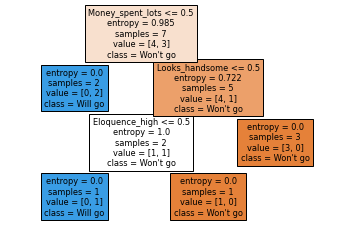

In [ ]:
plot_tree(
    dt, feature_names=df_train.columns, filled=True, class_names=["Won't go", "Will go"]
);

In [ ]:
# %matplotlib inline
# from matplotlib import pyplot as plt

# plt.rcParams["figure.figsize"] = (10, 8)

# import collections

# import numpy as np
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import GridSearchCV, cross_val_score
# from sklearn.preprocessing import LabelEncoder
# from sklearn.tree import DecisionTreeClassifier, plot_tree

### Функции для рассчета энтропии и прироста информации

In [ ]:
balls = [1 for i in range(9)] + [0 for i in range(11)]
balls

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# two groups
balls_left = [1 for i in range(8)] + [0 for i in range(5)]  # 8 blue and 5 yellow
balls_right = [1 for i in range(1)] + [0 for i in range(6)]  # 1 blue and 6 yellow

In [ ]:
from math import log

def entropy(a_list):
    lst = list(a_list)
    size = len(lst)
    entropy = 0
    set_elements = len(set(lst))
    if set_elements in [0, 1]:
        return 0
    for i in set(lst):
        occ = lst.count(i)
        entropy -= occ / size * log(occ / size, 2)
    return entropy

In [ ]:
print(entropy(balls))  # 9 blue and 11 yellow ones
print(entropy(balls_left))  # 8 blue and 5 yellow ones
print(entropy(balls_right))  # 1 blue and 6 yellow ones
print(entropy([1, 2, 3, 4, 5, 6]))  # entropy of a fair 6-sided die

0.9927744539878084
0.961236604722876
0.5916727785823275
2.584962500721156


In [ ]:
# information gain calculation
def information_gain(root, left, right):
    """ root - initial data, left and right - two partitions of initial data"""

    return (
        entropy(root)
        - 1.0 * len(left) / len(root) * entropy(left)
        - 1.0 * len(right) / len(root) * entropy(right)
    )

In [ ]:
print(information_gain(balls, balls_left, balls_right))

0.16088518841412436


In [ ]:
def information_gains(X, y):
    """Outputs information gain when splitting with each feature"""
    out = []
    for i in X.columns:
        out.append(information_gain(y, y[X[i] == 0], y[X[i] == 1]))
    return out

In [ ]:
information_gains(df_train, y)

[0.2916919971380598,
 0.12808527889139454,
 0.46956521111470706,
 0.005977711423774124,
 0.005977711423774124,
 0.02024420715375619,
 0.12808527889139454,
 0.46956521111470706]

In [ ]:
def btree(X, y, feature_names):
    clf = information_gains(X, y)
    best_feat_id = clf.index(max(clf))
    best_feature = feature_names[best_feat_id]
    print(f"Best feature to split: {best_feature}")

    x_left = X[X.iloc[:, best_feat_id] == 0]
    x_right = X[X.iloc[:, best_feat_id] == 1]
    print(f"Samples: {len(x_left)} (left) and {len(x_right)} (right)")

    y_left = y[X.iloc[:, best_feat_id] == 0]
    y_right = y[X.iloc[:, best_feat_id] == 1]
    entropy_left = entropy(y_left)
    entropy_right = entropy(y_right)
    print(f"Entropy: {entropy_left} (left) and {entropy_right} (right)")
    print("_" * 30 + "\n")
    if entropy_left != 0:
        print(f"Splitting the left group with {len(x_left)} samples:")
        btree(x_left, y_left, feature_names)
    if entropy_right != 0:
        print(f"Splitting the right group with {len(x_right)} samples:")
        btree(x_right, y_right, feature_names)

In [ ]:
btree(df_train, y, df_train.columns)

Best feature to split: Money_spent_lots
Samples: 2 (left) and 5 (right)
Entropy: 0 (left) and 0.7219280948873623 (right)
______________________________

Splitting the right group with 5 samples:
Best feature to split: Looks_repulsive
Samples: 3 (left) and 2 (right)
Entropy: 0 (left) and 1.0 (right)
______________________________

Splitting the right group with 2 samples:
Best feature to split: Eloquence_high
Samples: 1 (left) and 1 (right)
Entropy: 0 (left) and 0 (right)
______________________________



In [ ]:
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"

In [ ]:
data_train = pd.read_csv(DATA_PATH + "adult_train.csv", sep=";")
data_test = pd.read_csv(DATA_PATH + "adult_test.csv", sep=";")

In [ ]:
data_train.head(5)

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
print(data_test.count)
data_test = data_test[
    (data_test["Target"] == " >50K.") | (data_test["Target"] == " <=50K.")
]

<bound method DataFrame.count of                         Age      Workclass  ...         Country   Target
0      |1x3 Cross validator            NaN  ...             NaN      NaN
1                        25        Private  ...   United-States   <=50K.
2                        38        Private  ...   United-States   <=50K.
3                        28      Local-gov  ...   United-States    >50K.
4                        44        Private  ...   United-States    >50K.
...                     ...            ...  ...             ...      ...
16277                    39        Private  ...   United-States   <=50K.
16278                    64            NaN  ...   United-States   <=50K.
16279                    38        Private  ...   United-States   <=50K.
16280                    44        Private  ...   United-States   <=50K.
16281                    35   Self-emp-inc  ...   United-States    >50K.

[16282 rows x 15 columns]>


In [ ]:
data_test.count

<bound method DataFrame.count of       Age      Workclass    fnlwgt  ... Hours_per_week         Country   Target
1      25        Private  226802.0  ...           40.0   United-States   <=50K.
2      38        Private   89814.0  ...           50.0   United-States   <=50K.
3      28      Local-gov  336951.0  ...           40.0   United-States    >50K.
4      44        Private  160323.0  ...           40.0   United-States    >50K.
5      18            NaN  103497.0  ...           30.0   United-States   <=50K.
...    ..            ...       ...  ...            ...             ...      ...
16277  39        Private  215419.0  ...           36.0   United-States   <=50K.
16278  64            NaN  321403.0  ...           40.0   United-States   <=50K.
16279  38        Private  374983.0  ...           50.0   United-States   <=50K.
16280  44        Private   83891.0  ...           40.0   United-States   <=50K.
16281  35   Self-emp-inc  182148.0  ...           60.0   United-States    >50K.

[16281

In [ ]:
# encode target variable as integer
data_train.loc[data_train["Target"] == " <=50K", "Target"] = 0
data_train.loc[data_train["Target"] == " >50K", "Target"] = 1

data_test.loc[data_test["Target"] == " <=50K.", "Target"] = 0
data_test.loc[data_test["Target"] == " >50K.", "Target"] = 1

In [ ]:
data_test.head(5)

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,0
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,0
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,1
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,1
5,18,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,0


In [ ]:
data_test.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281,NaN,NaN,NaN,189436,105715,13492,116736,177831,238384,1.4904e+06
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281,NaN,NaN,NaN,10.0729,2.56755,1,9,10,12,16
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_train["Target"].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

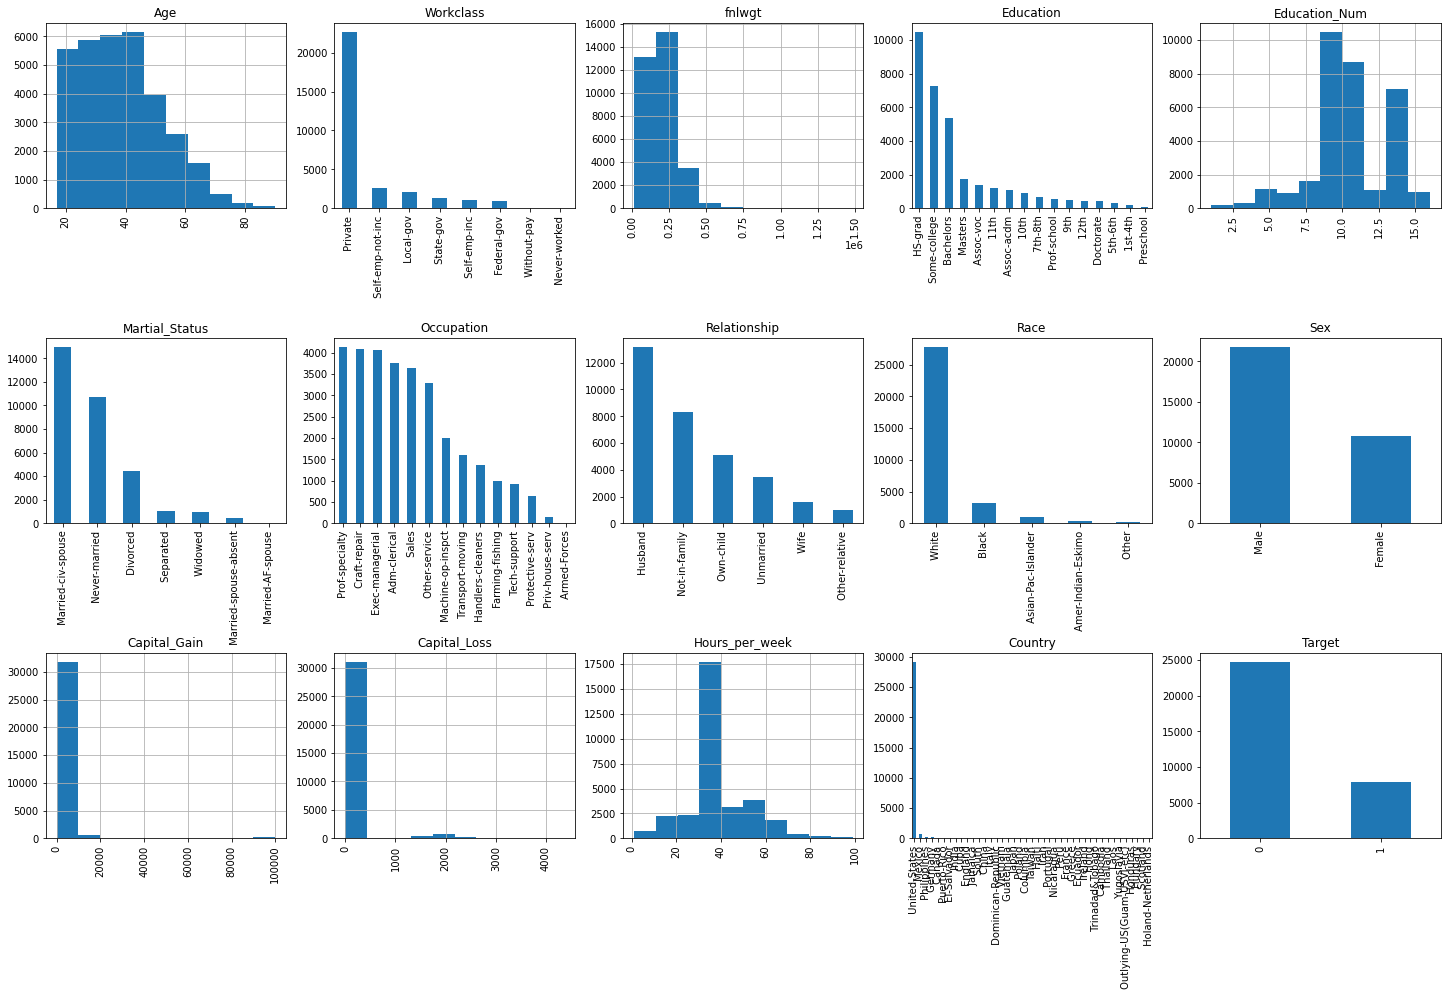

In [ ]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = int(data_train.shape[1] / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == np.object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2);

In [ ]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [ ]:
# we see some missing values
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         31978 non-null  object
 14  Target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [ ]:
# choose categorical and continuous features from data

categorical_columns = [
    c for c in data_train.columns if data_train[c].dtype.name == "object"
]
numerical_columns = [
    c for c in data_train.columns if data_train[c].dtype.name != "object"
]

print("categorical_columns:", categorical_columns)
print("numerical_columns:", numerical_columns)

categorical_columns: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
numerical_columns: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


In [ ]:
data_train["Workclass"].fillna(data_train["Workclass"].mode()[0], inplace=True)
data_train.mode()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,36.0,Private,123011,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,0
1,NaN,NaN,164190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,203488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for c in categorical_columns:
  data_train[c].fillna(data_train[c].mode()[0], inplace=True)
  data_test[c].fillna(data_test[c].mode()[0], inplace=True)

for c in numerical_columns:
    data_train[c].fillna(data_train[c].median(), inplace=True)
    data_test[c].fillna(data_train[c].median(), inplace=True)

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         32561 non-null  object
 14  Target          32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


In [ ]:
data_train.mode()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,36.0,Private,123011,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,0.0
1,NaN,NaN,164190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,203488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_train = pd.concat(
    [data_train[numerical_columns], pd.get_dummies(data_train[categorical_columns])],
    axis=1,
)

data_test = pd.concat(
    [data_test[numerical_columns], pd.get_dummies(data_test[categorical_columns])],
    axis=1,
)

In [ ]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [ ]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

In [ ]:
data_train.head(1)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,Workclass_ Self-emp-inc,Workclass_ Self-emp-not-inc,Workclass_ State-gov,Workclass_ Without-pay,Education_ 10th,Education_ 11th,Education_ 12th,Education_ 1st-4th,Education_ 5th-6th,Education_ 7th-8th,Education_ 9th,Education_ Assoc-acdm,Education_ Assoc-voc,Education_ Bachelors,Education_ Doctorate,Education_ HS-grad,Education_ Masters,Education_ Preschool,Education_ Prof-school,Education_ Some-college,Martial_Status_ Divorced,Martial_Status_ Married-AF-spouse,Martial_Status_ Married-civ-spouse,Martial_Status_ Married-spouse-absent,Martial_Status_ Never-married,Martial_Status_ Separated,Martial_Status_ Widowed,Occupation_ Adm-clerical,Occupation_ Armed-Forces,...,Country_ Canada,Country_ China,Country_ Columbia,Country_ Cuba,Country_ Dominican-Republic,Country_ Ecuador,Country_ El-Salvador,Country_ England,Country_ France,Country_ Germany,Country_ Greece,Country_ Guatemala,Country_ Haiti,Country_ Holand-Netherlands,Country_ Honduras,Country_ Hong,Country_ Hungary,Country_ India,Country_ Iran,Country_ Ireland,Country_ Italy,Country_ Jamaica,Country_ Japan,Country_ Laos,Country_ Mexico,Country_ Nicaragua,Country_ Outlying-US(Guam-USVI-etc),Country_ Peru,Country_ Philippines,Country_ Poland,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
data_test["Country_ Holand-Netherlands"] = 0

In [ ]:
set(data_train.columns) - set(data_test.columns)

set()

In [ ]:
X_train = data_train.drop(["Target"], axis=1)
y_train = data_train["Target"]

X_test = data_test.drop(["Target"], axis=1)
y_test = data_test["Target"]

In [ ]:
y_train

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: Target, Length: 32561, dtype: int64

In [ ]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=17)

In [ ]:
tree_predictions = tree.predict(X_test[X_train.columns])

In [ ]:
accuracy_score(y_test, tree_predictions)

0.8447884036607088

In [ ]:
%%time
tree_params = {"max_depth": range(2, 11)}

locally_best_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=17), tree_params, cv=5
)

locally_best_tree.fit(X_train, y_train)

CPU times: user 7.55 s, sys: 49.5 ms, total: 7.6 s
Wall time: 7.6 s


In [ ]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Best params: {'max_depth': 9}
Best cross validaton score 0.8565770273854106


In [ ]:
tuned_tree = DecisionTreeClassifier(max_depth=9, random_state=17)
tuned_tree.fit(X_train, y_train)
tuned_tree_predictions = tuned_tree.predict(X_test)
accuracy_score(y_test, tuned_tree_predictions)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


0.847798046803022

## На собственных данных

### Инициализация

In [ ]:
df = pd.read_csv("vine.csv")
df.head(5) # Показываем первые 5 элементов

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
df.shape

(1599, 12)

### Подготовка данных

In [ ]:
df = df.rename(columns={
    "fixed acidity": "FA",
    "volatile acidity": "VA",
    "citric acid": "CA",
    "residual sugar": "RS",
    "free sulfur dioxide": "FSD",
    "total sulfur dioxide": "total_SD"
})

In [ ]:
# Так как в исходном файле не было test даты, разделим для примера на две части исходный набор
df_train = df[0:1000]
df_test = df[1000:-1]

In [ ]:
df_train.shape, df_test.shape

((1000, 12), (598, 12))

In [ ]:
df_train.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
FA,1000.0,8.728900,1.836602,4.60000,7.400000,8.3000,9.8000,15.9000
VA,1000.0,0.528290,0.178550,0.12000,0.400000,0.5200,0.6350,1.3300
CA,1000.0,0.294580,0.200153,0.00000,0.120000,0.2800,0.4700,1.0000
RS,1000.0,2.579400,1.238960,1.20000,2.000000,2.3000,2.7000,15.5000
chlorides,1000.0,0.090375,0.049917,0.01200,0.072000,0.0810,0.0930,0.6110
FSD,1000.0,15.171000,9.972949,1.00000,7.000000,13.0000,20.2500,68.0000
total_SD,1000.0,48.328000,33.309788,6.00000,23.000000,39.0000,64.2500,165.0000
density,1000.0,0.997349,0.001778,0.99064,0.996372,0.9973,0.9984,1.0032
pH,1000.0,3.299100,0.157948,2.74000,3.190000,3.3000,3.4000,3.9000
sulphates,1000.0,0.668520,0.183210,0.33000,0.560000,0.6200,0.7400,2.0000


In [ ]:
df_test.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
FA,598.0,7.639130,1.310098,5.00000,6.80000,7.400000,8.20000,12.60000
VA,598.0,0.527400,0.179986,0.16000,0.39000,0.520000,0.64000,1.58000
CA,598.0,0.231171,0.178749,0.00000,0.07000,0.220000,0.36000,0.78000
RS,598.0,2.469147,1.656164,0.90000,1.80000,2.100000,2.40000,15.40000
chlorides,598.0,0.082637,0.041492,0.03800,0.06600,0.076000,0.08600,0.41500
FSD,598.0,17.048495,11.145534,3.00000,8.00000,15.000000,24.00000,72.00000
total_SD,598.0,43.364548,32.005235,7.00000,20.00000,35.000000,59.00000,289.00000
density,598.0,0.995741,0.001619,0.99007,0.99488,0.995775,0.99668,1.00369
pH,598.0,3.331070,0.146296,2.88000,3.24000,3.330000,3.41000,4.01000
sulphates,598.0,0.640803,0.142336,0.37000,0.54000,0.610000,0.72000,1.34000


In [ ]:
df_train.quality.value_counts()

5    468
6    364
7    121
4     32
8     10
3      5
Name: quality, dtype: int64

In [ ]:
df_train.shape

(1000, 12)

### Визуализация данных

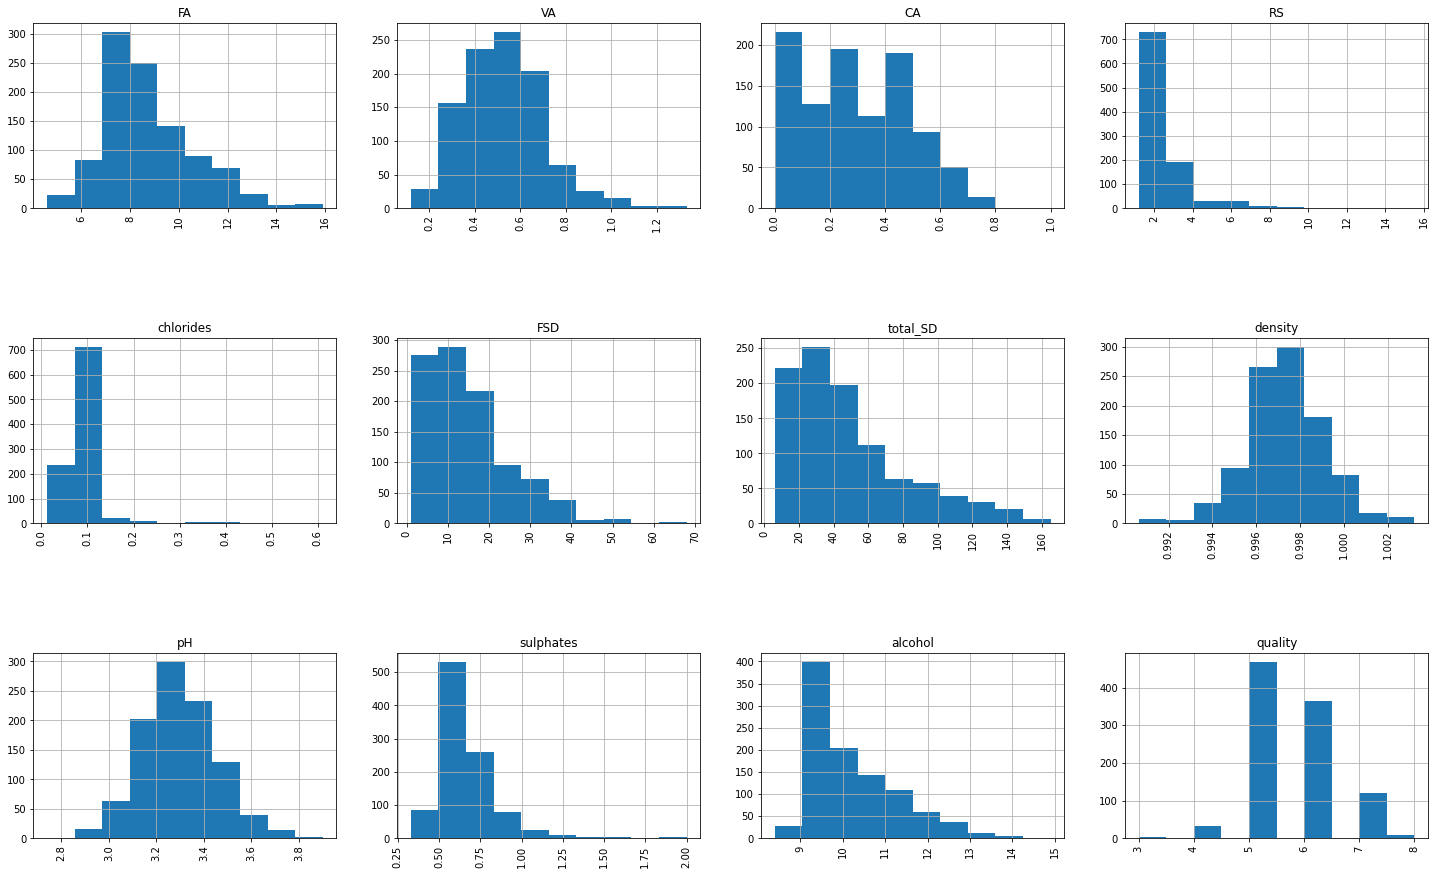

In [ ]:
fig = plt.figure(figsize=(25, 15))
cols = 4
rows = int(df_train.shape[1] / cols)
for i, column in enumerate(df_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if df_train.dtypes[column] == np.object:
        df_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        df_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2);

### Удаление дупликатов

In [ ]:
duplicate_rows_df = df_train[df_train.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (149, 12)


In [ ]:
df_train = df_train.drop_duplicates()

In [ ]:
df_train.count()

FA           851
VA           851
CA           851
RS           851
chlorides    851
FSD          851
total_SD     851
density      851
pH           851
sulphates    851
alcohol      851
quality      851
dtype: int64

### Проверка на нулевые объекты

In [ ]:
print(df.isnull().sum()) 

FA           0
VA           0
CA           0
RS           0
chlorides    0
FSD          0
total_SD     0
density      0
pH           0
sulphates    0
alcohol      0
quality      0
dtype: int64


In [ ]:
df_train.dtypes

FA           float64
VA           float64
CA           float64
RS           float64
chlorides    float64
FSD          float64
total_SD     float64
density      float64
pH           float64
sulphates    float64
alcohol      float64
quality        int64
dtype: object

### Преобразование типов данных к Int

In [ ]:
df_train["FA"] = df_train["FA"].astype(int)
df_train["VA"] = df_train["VA"].astype(int)
df_train["CA"] = df_train["CA"].astype(int)
df_train["RS"] = df_train["RS"].astype(int)
df_train["chlorides"] = df_train["chlorides"].astype(int)
df_train["FSD"] = df_train["FSD"].astype(int)
df_train["total_SD"] = df_train["total_SD"].astype(int)
df_train["density"] = df_train["chlorides"].astype(int)
df_train["pH"] = df_train["FSD"].astype(int)
df_train["sulphates"] = df_train["total_SD"].astype(int)
df_train["alcohol"] = df_train["alcohol"].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
df_train.dtypes

FA           int64
VA           int64
CA           int64
RS           int64
chlorides    int64
FSD          int64
total_SD     int64
density      int64
pH           int64
sulphates    int64
alcohol      int64
quality      int64
dtype: object

In [ ]:
df_train

,FA,VA,CA,RS,chlorides,FSD,total_SD,density,pH,sulphates,alcohol,quality
0,7,0,0,1,0,11,34,0,11,34,9,5
1,7,0,0,2,0,25,67,0,25,67,9,5
2,7,0,0,2,0,15,54,0,15,54,9,5
3,11,0,0,1,0,17,60,0,17,60,9,6
5,7,0,0,1,0,13,40,0,13,40,9,5
...,...,...,...,...,...,...,...,...,...,...,...,...
994,10,0,0,2,0,20,88,0,20,88,9,5
995,7,0,0,2,0,19,41,0,19,41,10,6
996,5,0,0,2,0,3,11,0,3,11,12,7
998,8,0,0,1,0,4,10,0,4,10,9,6


### Проверка схожести фреймов данных тестовой и тренивовочной выборки

In [ ]:
set(df_train.columns) - set(df_test.columns)

set()

### Дерево решений без параметров

In [ ]:
X_train = df_train.drop(["quality"], axis=1)
y_train = df_train["quality"]

X_test = df_test.drop(["quality"], axis=1)
y_test = df_test["quality"]

In [ ]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=17)

In [ ]:
tree_predictions = tree.predict(X_test[X_train.columns])

In [ ]:
accuracy_score(y_test, tree_predictions)

0.46321070234113715

### Дерево решений с настройкой параметров

In [ ]:
%%time
tree_params = {"max_depth": range(0, 11)}

locally_best_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=17), tree_params, cv=5
)

locally_best_tree.fit(X_train, y_train)

CPU times: user 396 ms, sys: 2.94 ms, total: 399 ms
Wall time: 398 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 55.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 306, in fit
    raise ValueError("max_depth must be greater than zero. ")
ValueError: max_depth must be greater than ze

In [ ]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Best params: {'max_depth': 1}
Best cross validaton score 0.5652356381148951


In [ ]:
tuned_tree = DecisionTreeClassifier(max_depth=1, random_state=17)
tuned_tree.fit(X_train, y_train)
tuned_tree_predictions = tuned_tree.predict(X_test)
accuracy_score(y_test, tuned_tree_predictions)

0.5133779264214047